In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
df = pd.read_csv('../data/raw_data/btc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.loc['2020-01-01':'2024-12-31']

In [33]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1827 non-null   float64
 1   high    1827 non-null   float64
 2   low     1827 non-null   float64
 3   close   1827 non-null   float64
 4   volume  1827 non-null   float64
dtypes: float64(5)
memory usage: 85.6 KB


In [31]:
print(df.describe())

                open           high            low          close  \
count    1827.000000    1827.000000    1827.000000    1827.000000   
mean    36256.876650   37112.128533   35359.703810   36304.237718   
std     21084.475307   21559.099335   20600.051669   21116.123701   
min      4800.010000    5365.420000    3782.130000    4800.000000   
25%     19580.470000   20144.220000   19158.210000   19610.295000   
50%     32176.450000   33340.000000   30837.370000   32254.200000   
75%     50645.195000   51918.165000   48914.600000   50722.795000   
max    106133.740000  108353.000000  105321.490000  106133.740000   

              volume  
count    1827.000000  
mean    84424.512317  
std     91573.040113  
min      7308.955420  
25%     33626.828065  
50%     52601.052750  
75%     88034.883112  
max    760705.362783  


In [34]:
n = len(df)
print(f'Len data: {n}')
bins = int(np.sqrt(n))
print(f'Num of bins: {bins}')

Len data: 1827
Num of bins: 42


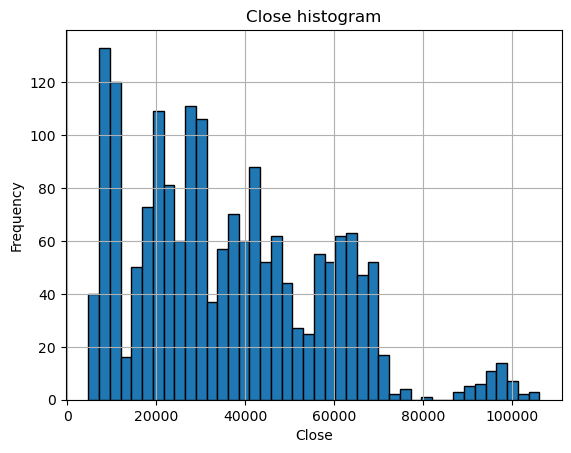

In [35]:
df.close.hist(bins=bins, edgecolor='black')
plt.title('Close histogram')
plt.xlabel('Close')
plt.ylabel('Frequency')
plt.show()

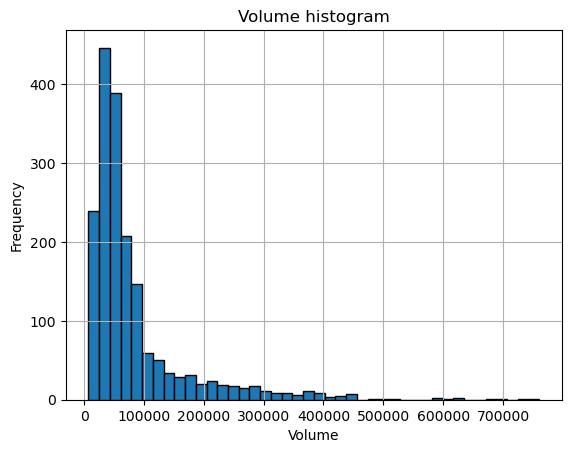

In [36]:
df.volume.hist(bins=bins, edgecolor='black')
plt.title('Volume histogram')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

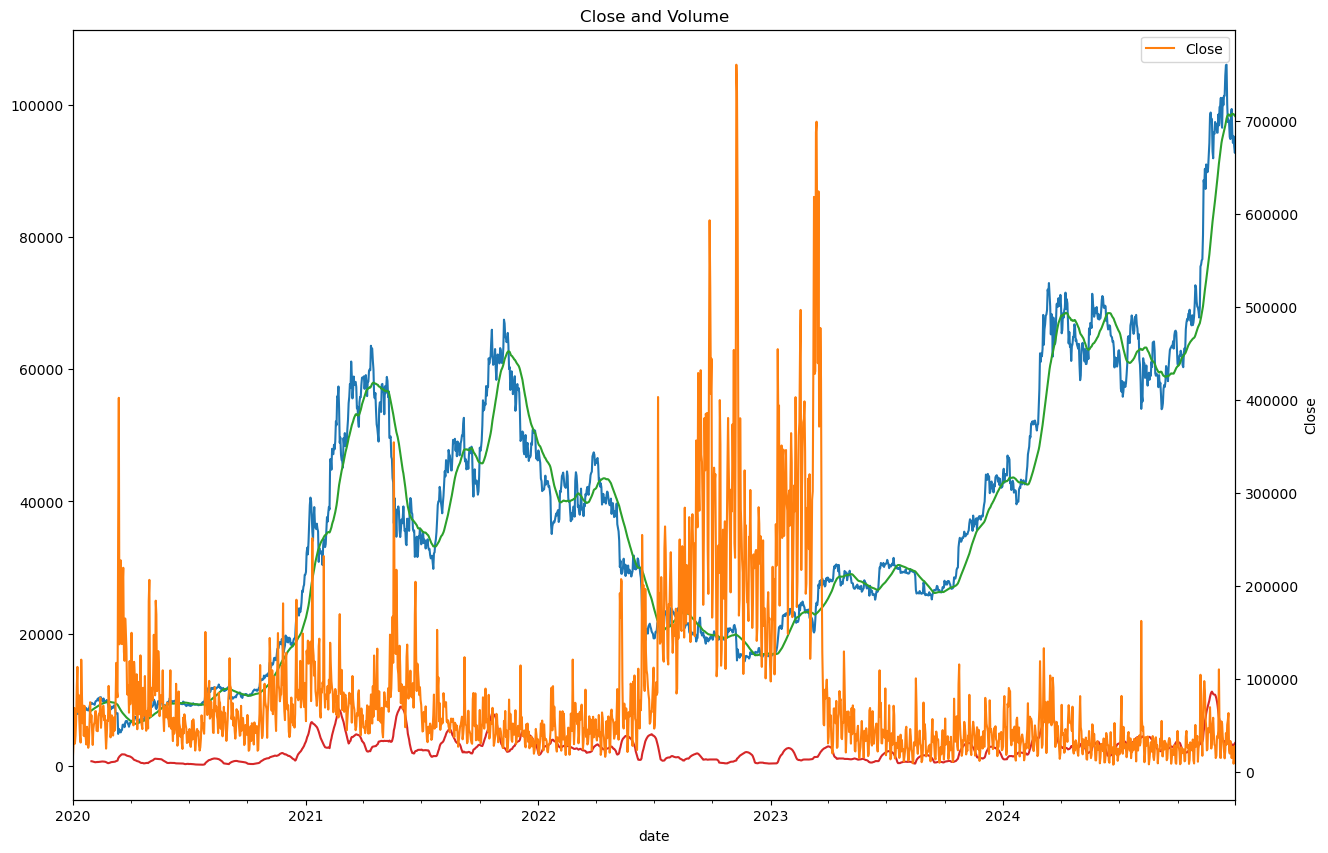

In [39]:
plt.figure(figsize=(15, 10))
df['close'].plot()
df['volume'].plot(secondary_y=True, label='Volume')
df['close'].rolling(window=30).mean().plot()
df['close'].rolling(window=30).std().plot()
plt.title('Close and Volume')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Close', 'Volume', 'Close 30 day mean', 'Close 30 day std'])
plt.show()

C:\Users\santi\AppData\Local\Temp\ipykernel_13884\1865928357.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['close'].resample('B').mean().plot()
C:\Users\santi\AppData\Local\Temp\ipykernel_13884\1865928357.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['close'].resample('B').mean().plot()


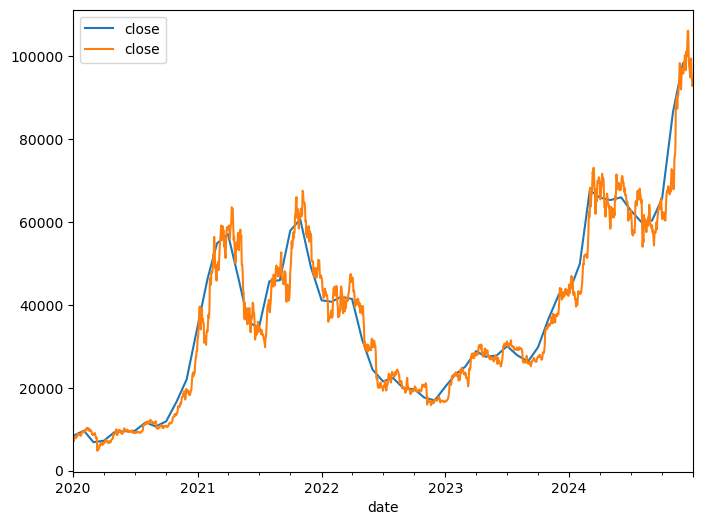

In [40]:
plt.figure(figsize=(8, 6))
df['close'].resample('M').mean().plot()
df['close'].resample('B').mean().plot()
plt.legend()

C:\Users\santi\AppData\Local\Temp\ipykernel_13884\3414365292.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['volume'].resample('B').median().plot()
C:\Users\santi\AppData\Local\Temp\ipykernel_13884\3414365292.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['volume'].resample('B').median().plot()


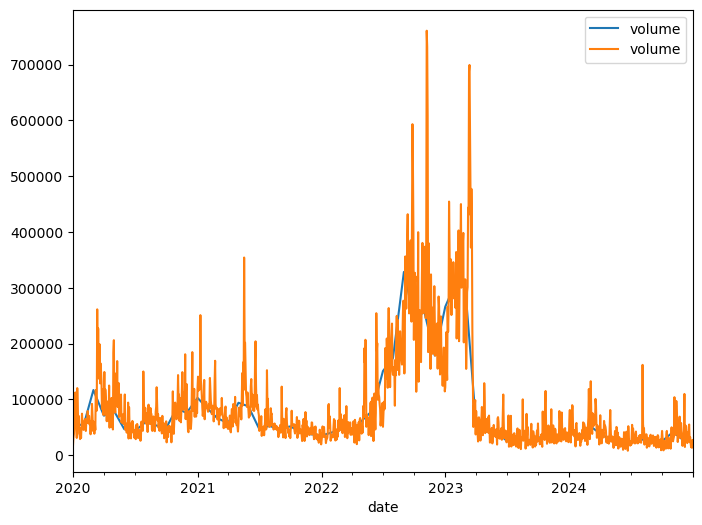

In [41]:
plt.figure(figsize=(8, 6))
df['volume'].resample('M').median().plot()
df['volume'].resample('B').median().plot()
plt.legend()

In [45]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

price_columns = ['close', 'volume']
outliers_count = {col: count_outliers(df[col]) for col in price_columns}
print(outliers_count)

{'close': 21, 'volume': 224}


c:\Users\santi\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


Text(0.5, 1.0, 'Boxplot of close')

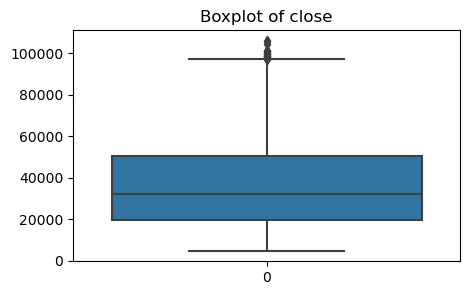

In [46]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['close'])
plt.title('Boxplot of close')

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


Text(0.5, 1.0, 'Boxplot of volume')

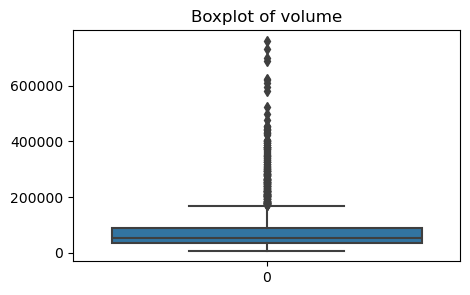

In [47]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['volume'])
plt.title('Boxplot of volume')

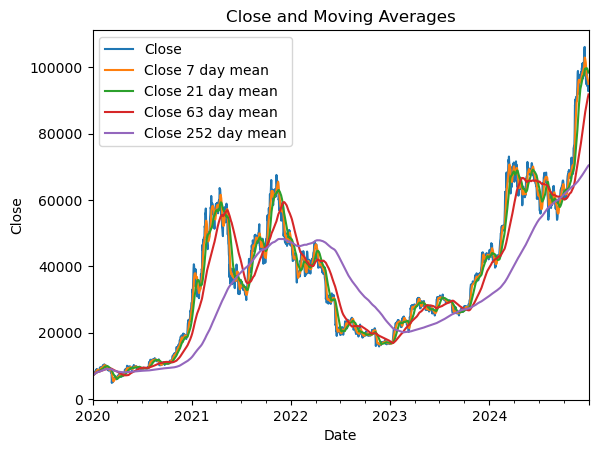

In [49]:
df['close'].plot()
df['close'].rolling(7, min_periods=1).mean().plot()
df['close'].rolling(21, min_periods=1).mean().plot()
df['close'].rolling(63, min_periods=1).mean().plot()
df['close'].rolling(252, min_periods=1).mean().plot()
plt.legend(['Close', 'Close 7 day mean', 'Close 21 day mean', 'Close 63 day mean', 'Close 252 day mean'])
plt.title('Close and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [50]:
df['log_close'] = np.log(df['close'])
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['log_returns_7'] = df['log_returns'].rolling(7, min_periods=1).mean()
df['log_returns_21'] = df['log_returns'].rolling(21, min_periods=1).mean()

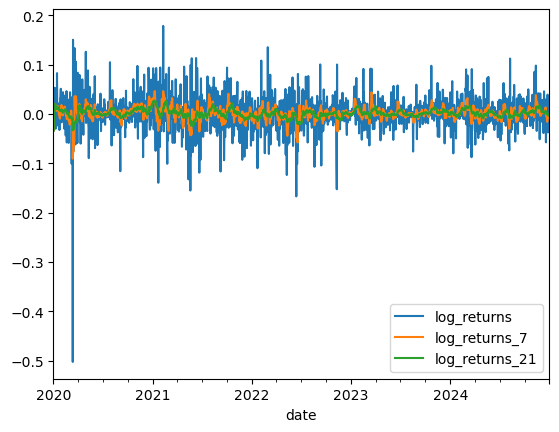

In [51]:
df['log_returns'].plot()
df['log_returns_7'].plot()
df['log_returns_21'].plot()
plt.legend()

In [52]:
df['volatility_7'] = df['log_returns'].rolling(7, min_periods=1).std()
df['volatility_21'] = df['log_returns'].rolling(21, min_periods=1).std()
df['volatility_63'] = df['log_returns'].rolling(63, min_periods=1).std()
df['volatility_252'] = df['log_returns'].rolling(252, min_periods=1).std()

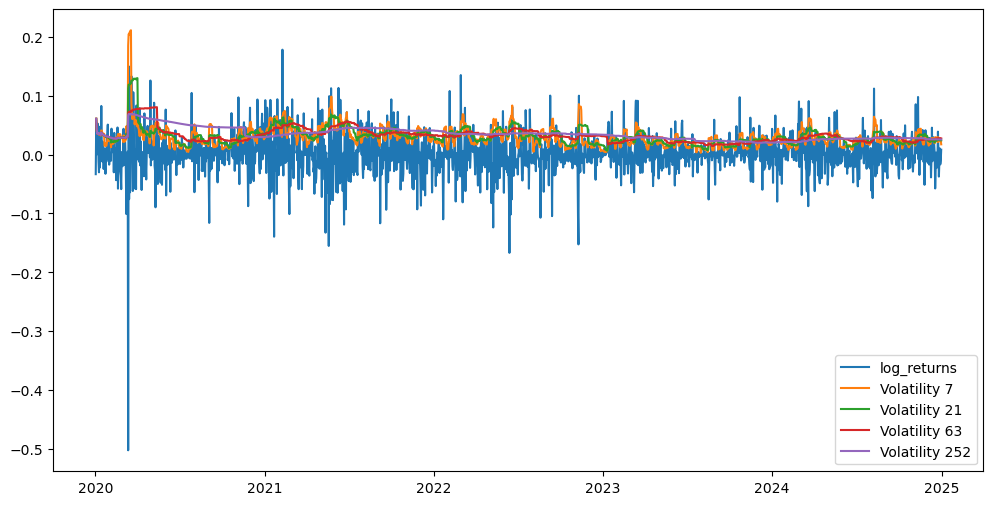

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(df['log_returns'], label='log_returns')
plt.plot(df['volatility_7'], label='Volatility 7')
plt.plot(df['volatility_21'], label='Volatility 21')
plt.plot(df['volatility_63'], label='Volatility 63')
plt.plot(df['volatility_252'], label='Volatility 252')
plt.legend()
plt.show()

In [54]:
df['ema_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
df['ema_63'] = df['close'].ewm(span=63, adjust=False).mean()
df['ema_252'] = df['close'].ewm(span=252, adjust=False).mean()

In [55]:
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14, min_periods=1).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=1).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

In [57]:
result = adfuller(df['log_returns'].dropna())

In [58]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Lags used: {result[2]}')
print(f'Number of observations: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] > 0.05:
    print('Data is not stationary (fail to reject H0)')
else:
    print('Data is stationary (reject H0)')

ADF Statistic: -20.09840887333571
p-value: 0.0
Lags used: 3
Number of observations: 1822
Critical Values:
	1%: -3.4339441475744668
	5%: -2.8631276157416945
	10%: -2.5676151930364455
Data is stationary (reject H0)


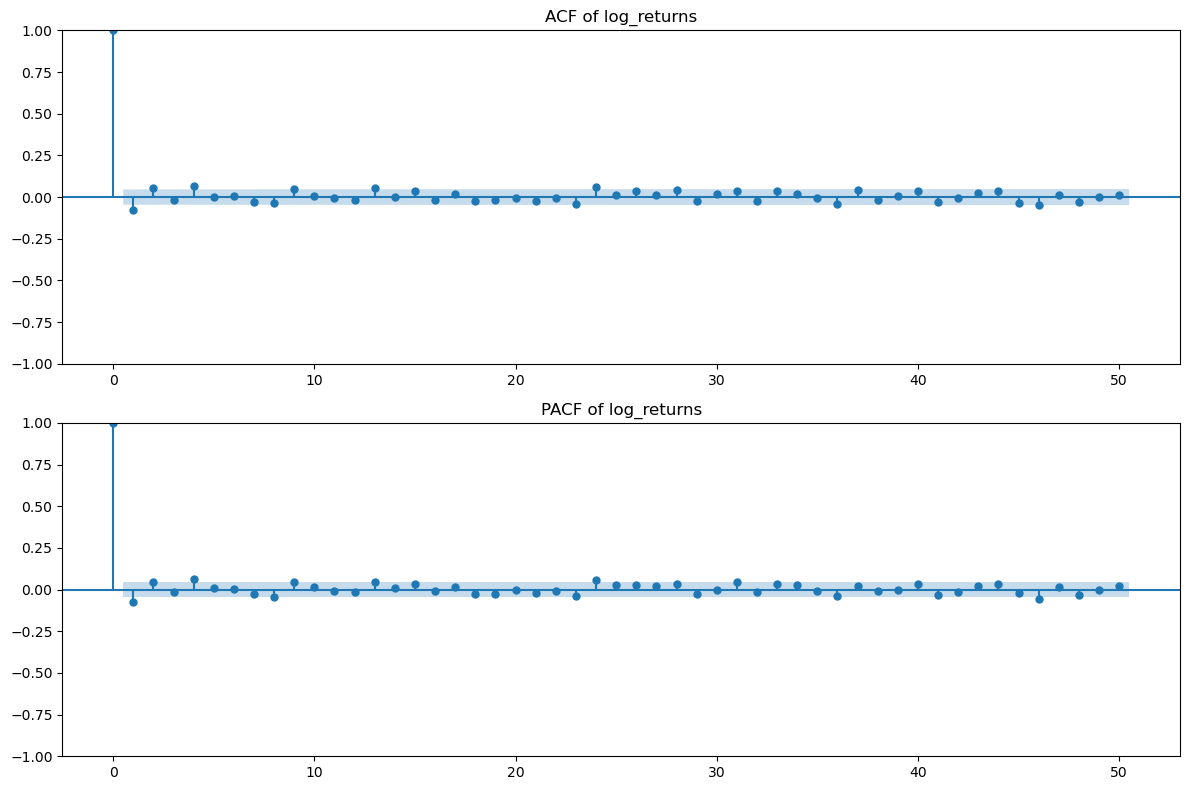

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(df['log_returns'].dropna(), lags=50, ax=ax[0])
ax[0].set_title('ACF of log_returns')
sm.graphics.tsa.plot_pacf(df['log_returns'].dropna(), lags=50, ax=ax[1])
ax[1].set_title('PACF of log_returns')
plt.tight_layout()
plt.show()

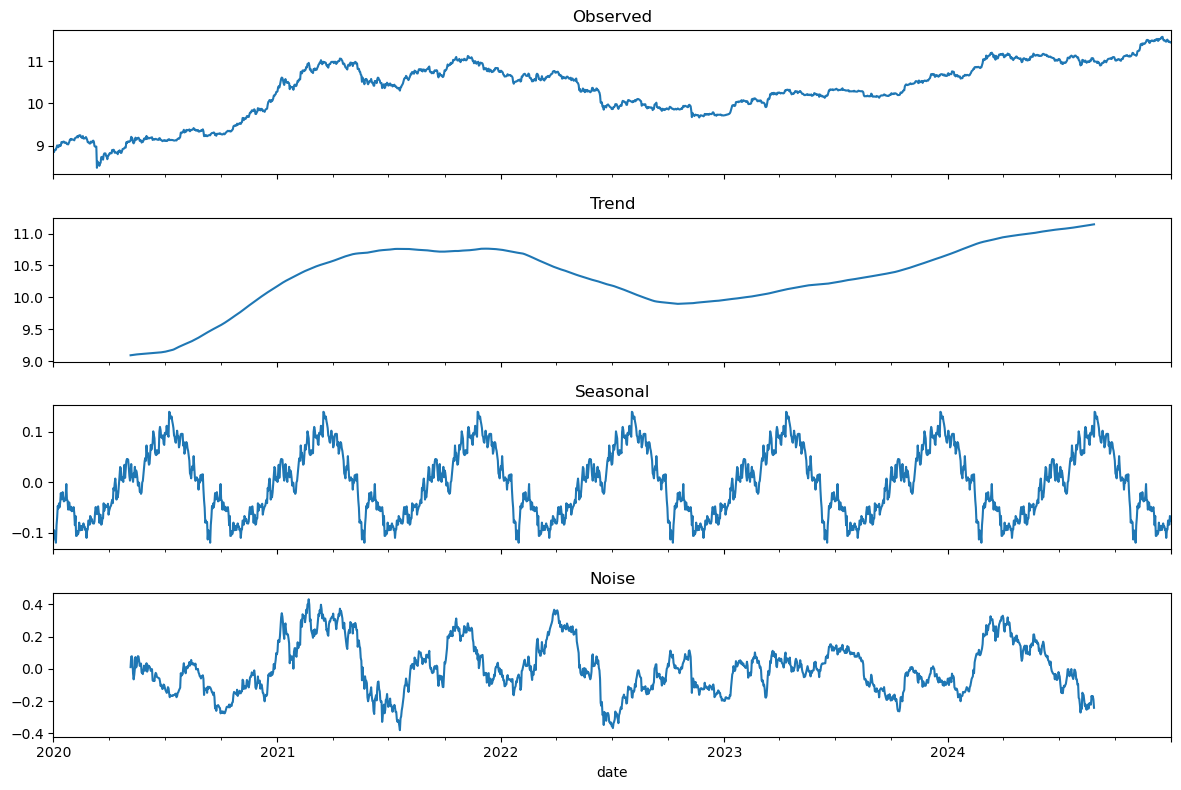

In [60]:
decomposition = seasonal_decompose(df['log_close'], model='additive', period=252)
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Noise')
plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

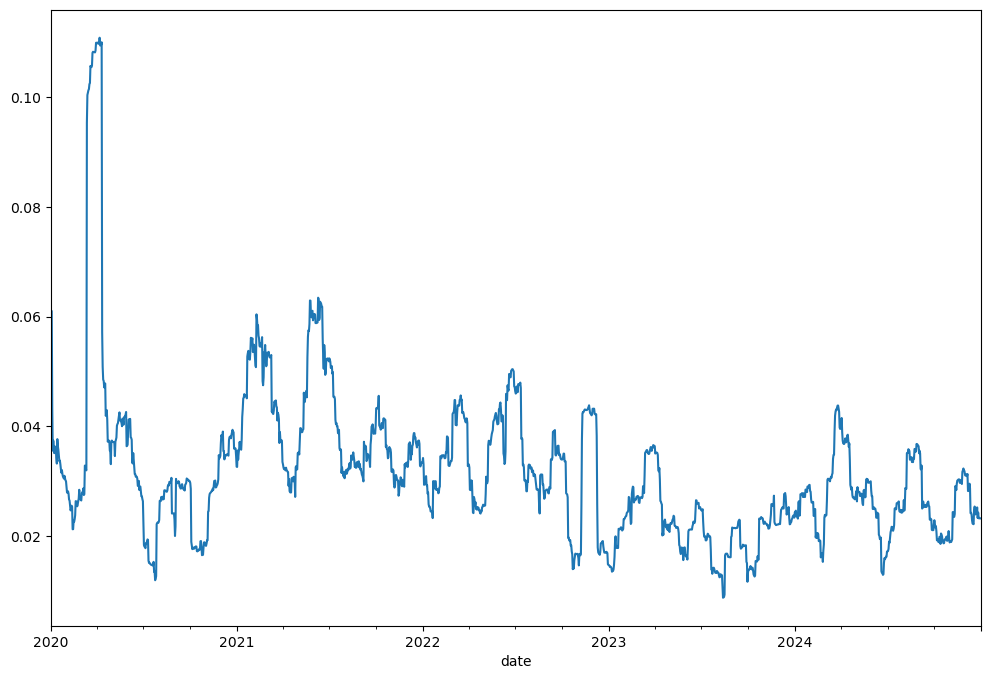

In [61]:
df['volatility_30'] = df['log_returns'].rolling(30, min_periods=1).std()

plt.figure(figsize=(12, 8))
df['volatility_30'].plot()

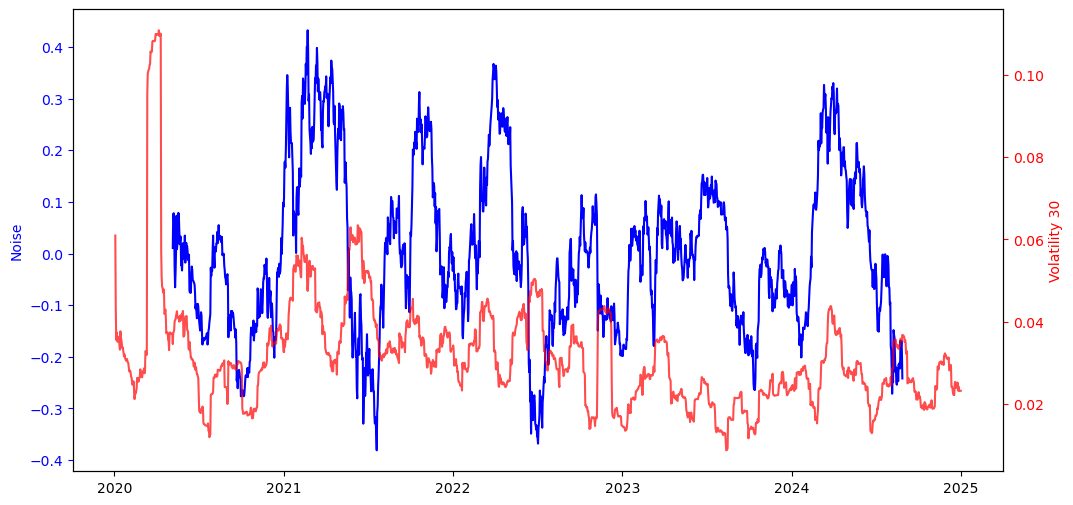

In [62]:
fig, ax1 = plt.subplots(figsize=(12, 6))

noise = decomposition.resid.dropna()
ax1.plot(noise, color='blue', label='Noise')
ax1.set_ylabel('Noise', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.plot(df['volatility_30'], color='red', label='Volatility 30', alpha=0.7)
ax2.set_ylabel('Volatility 30', color='red')
ax2.tick_params('y', colors='red')

plt.show()

In [63]:
correl = noise.corr(df['volatility_30'])
print(f'Correlation between noise and volatility_30: {correl}')

Correlation between noise and volatility_30: 0.13627916939074639
